# Context
AllLife Bank wants to focus on its credit card customer base in the next financial year. They have been advised by their marketing research team, that the penetration in the market can be improved. Based on this input, the Marketing team proposes to run personalized campaigns to target new customers as well as upsell to existing customers. Another insight from the market research was that the customers perceive the support services of the back poorly. Based on this, the Operations team wants to upgrade the service delivery model, to ensure that customer queries are resolved faster. Head of Marketing and Head of Delivery both decide to reach out to the Data Science team for help

 

# Objective
To identify different segments in the existing customer, based on their spending patterns as well as past interaction with the bank, using clustering algorithms, and provide recommendations to the bank on how to better market to and service these customers.

 

# Data Description
The data provided is of various customers of a bank and their financial attributes like credit limit, the total number of credit cards the customer has, and different channels through which customers have contacted the bank for any queries (including visiting the bank, online and through a call center).

# Data Dictionary

* Sl_No: Primary key of the records
* Customer Key: Customer identification number
* Average Credit Limit: Average credit limit of each customer for all credit cards
* Total credit cards: Total number of credit cards possessed by the customer
* Total visits bank: Total number of visits that customer made (yearly) personally to the bank
* Total visits online: Total number of visits or online logins made by the customer (yearly)
* Total calls made: Total number of calls made by the customer to the bank or its customer service department (yearly)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option("display.max_columns", None)

from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from yellowbrick.cluster.elbow import KElbowVisualizer
from yellowbrick.cluster.silhouette import SilhouetteVisualizer
from scipy.cluster.hierarchy import linkage, dendrogram, cophenet
from scipy.spatial.distance import pdist

from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore")

sns.set()

# Data Overview

In [2]:
bank = pd.read_excel("Credit Card Customer Data.xlsx")

In [3]:
df = bank.copy()

In [4]:
df.shape

(660, 7)

In [5]:
df.head()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Sl_No                660 non-null    int64
 1   Customer Key         660 non-null    int64
 2   Avg_Credit_Limit     660 non-null    int64
 3   Total_Credit_Cards   660 non-null    int64
 4   Total_visits_bank    660 non-null    int64
 5   Total_visits_online  660 non-null    int64
 6   Total_calls_made     660 non-null    int64
dtypes: int64(7)
memory usage: 36.2 KB


- The dataset consists of 660 rows and 7 columns. All columns are integers.
- Column name `Customer Key` needs to be fixed.

**Fix column name**

In [7]:
df.rename(columns = {"Customer Key": "Customer_Key"}, inplace = True)

**Check missing values**

In [8]:
df.isnull().sum()

Sl_No                  0
Customer_Key           0
Avg_Credit_Limit       0
Total_Credit_Cards     0
Total_visits_bank      0
Total_visits_online    0
Total_calls_made       0
dtype: int64

- No missing values.

**Check unique values**

In [9]:
df.nunique()

Sl_No                  660
Customer_Key           655
Avg_Credit_Limit       110
Total_Credit_Cards      10
Total_visits_bank        6
Total_visits_online     16
Total_calls_made        11
dtype: int64

- `Sl_No` is the primary key of the records, with 660 unique values. It would not provide information for our clustering, so drop it.
- `Customer_Key` is customer identification number. Only use it to match the result of clustering but not for model building. Only 655 unique values indicate the existence of duplicates.

# Data Preparation
**Check Duplicate `Customer_Key`**

In [10]:
df.loc[df.duplicated(subset = "Customer_Key"), "Customer_Key"].values

array([47437, 96929, 37252, 50706, 97935])

- Five Customer Keys are repeated. Check these obserevations.

In [11]:
duplicate_keys = [47437, 96929, 37252, 50706, 97935]
df[df.Customer_Key.isin(duplicate_keys)].sort_values(by = "Customer_Key")    # sort duplicates by customer key

,Sl_No,Customer_Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
48,49,37252,6000,4,0,2,8
432,433,37252,59000,6,2,1,2
4,5,47437,100000,6,0,12,3
332,333,47437,17000,7,3,1,0
411,412,50706,44000,4,5,0,2
541,542,50706,60000,7,5,2,2
391,392,96929,13000,4,5,0,0
398,399,96929,67000,6,2,2,2
104,105,97935,17000,2,1,2,10
632,633,97935,187000,7,1,7,0


- Observations with identical `Customer_Key` have totally different Average Credit Limit/ Total credit cards/ Total visits bank/ Total visits online/ Total calls made.

**Combine duplicate records.**

In [12]:
attribute_cols = df.columns.to_list()[2:]   # attibute column to combine
idx = df[df.Customer_Key.isin(duplicate_keys)].sort_values(by = "Customer_Key").index  # indices of duplicate rows

for i in range(0, len(idx), 2):
    for col in attribute_cols:
        df.loc[idx[i], col] += df.loc[idx[i + 1], col]   # merge the latter record to the first one

df = df.drop_duplicates(subset = "Customer_Key", keep = 'first') # keep the first occurrence
df[df.Customer_Key.isin(duplicate_keys)].sort_values(by = "Customer_Key")  # check duplicates again

,Sl_No,Customer_Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
48,49,37252,65000,10,2,3,10
4,5,47437,117000,13,3,13,3
411,412,50706,104000,11,10,2,4
391,392,96929,80000,10,7,2,2
104,105,97935,204000,9,2,9,10


**Drop `Sl_No` column**

In [13]:
df = df.drop(columns = "Sl_No")

**Check data description**

In [14]:
df.describe()

,Customer_Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
count,655.000000,655.000000,655.000000,655.000000,655.000000,655.000000
mean,55058.158779,34838.167939,4.741985,2.421374,2.625954,3.610687
std,25606.965469,38000.419397,2.229012,1.657944,2.952571,2.869678
min,11265.000000,3000.000000,1.000000,0.000000,0.000000,0.000000
25%,33623.500000,10000.000000,3.000000,1.000000,1.000000,1.000000
50%,53898.000000,18000.000000,5.000000,2.000000,2.000000,3.000000
75%,77084.500000,48500.000000,6.000000,4.000000,4.000000,5.000000
max,99843.000000,204000.000000,13.000000,10.000000,15.000000,10.000000


- `Avg_Credit_Limit` is right skewed and has a wide range from 3000 to 204000.
- The remaining columns have similar range from 0 to 15 and almost equal mean and median.

# Univariate Analysis

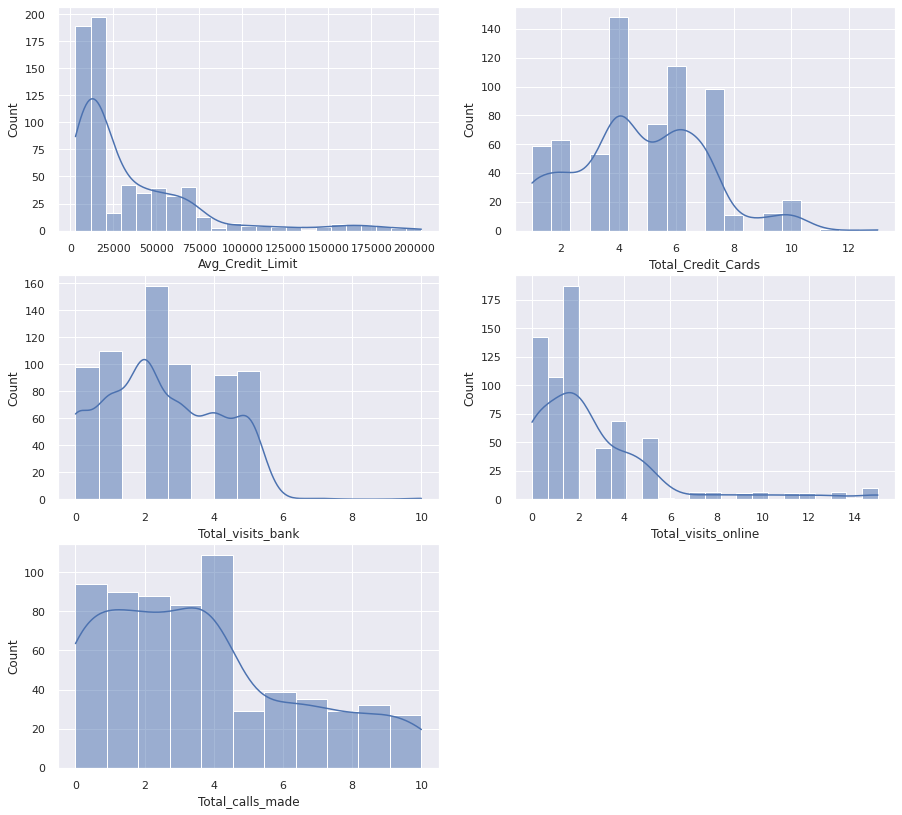

In [15]:
plt.figure(figsize = (15,14))
for i,col in enumerate(attribute_cols):
    plt.subplot(3, 2, i + 1)
    sns.histplot(df[col], kde = True);

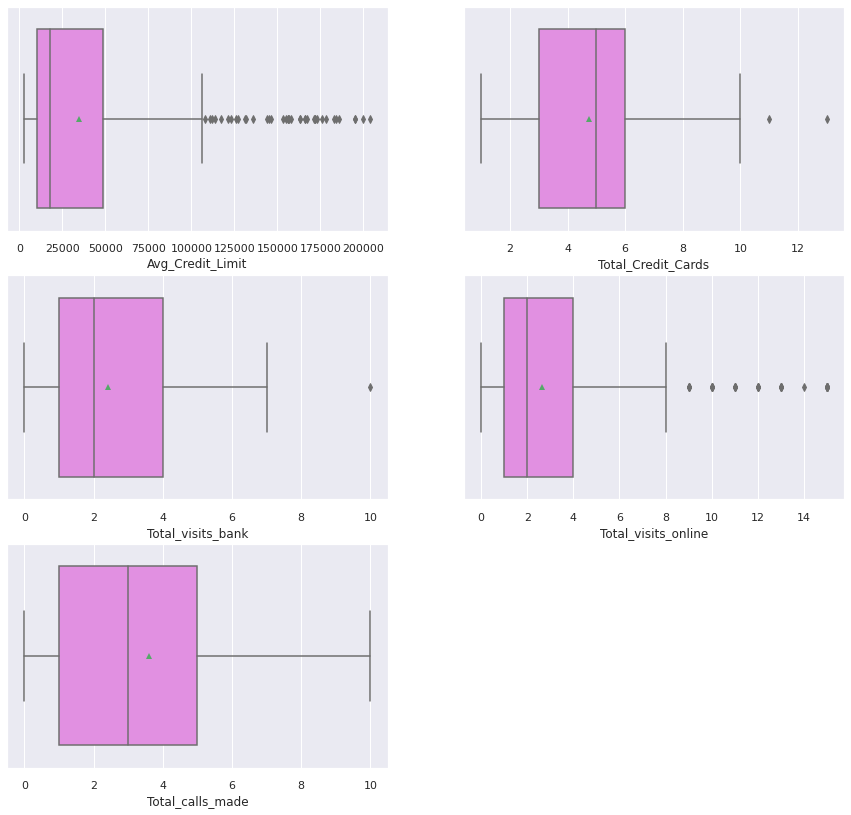

In [16]:
plt.figure(figsize = (15,14))
for i,col in enumerate(attribute_cols):
    plt.subplot(3, 2, i + 1)
    sns.boxplot(x = col, data = df, showmeans = True, color = "violet");

- Most customers have credit limit less than 25000. Lots of outliers on the right side.
- All customers have at least one credit card. On average five credit cards per customer. Most customers have no more than six credit cards. 
- Most customers visit the bank less than six times yearly. Some never visit the bank.
- Most customers use online service less than four times yearly. Some never use it. There're also a bunch of customers login as frequently as 12+ times yearly.
- Most customers contact the bank by phone no more than four times yearly. Some never call.

# Bivariate Analysis

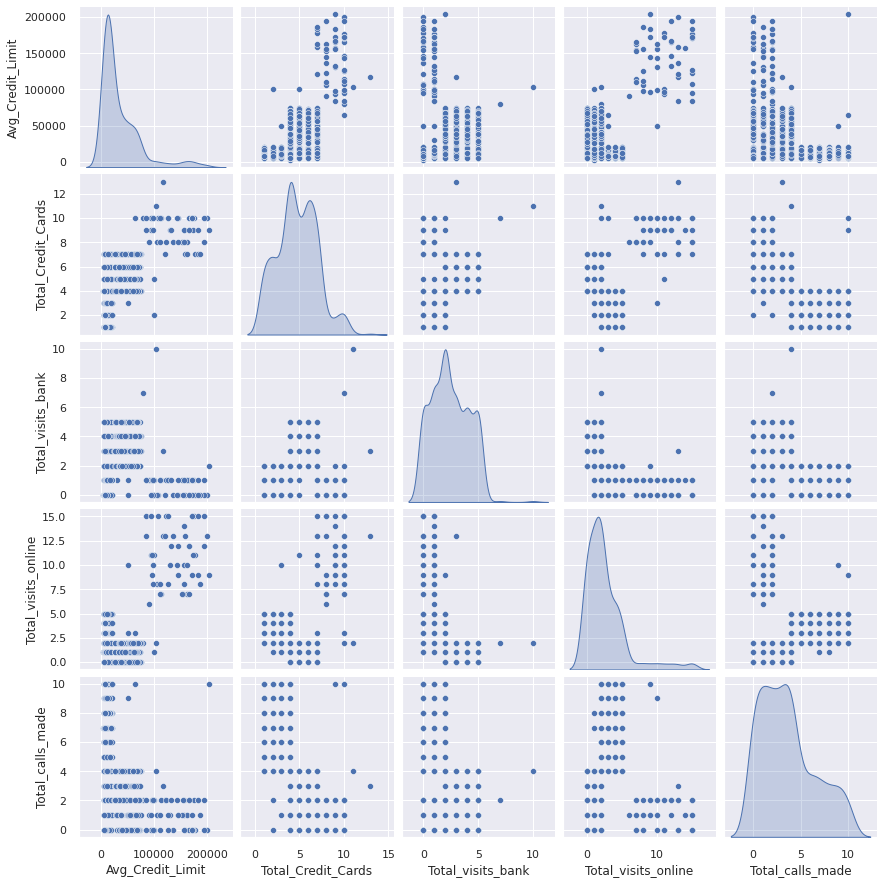

In [17]:
sns.pairplot(data = df[attribute_cols], diag_kind = "kde");

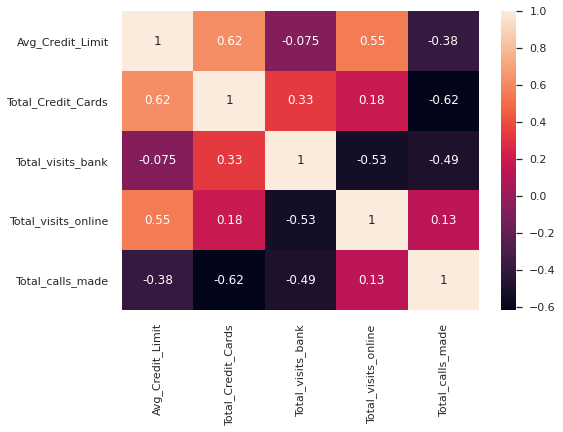

In [18]:
sns.heatmap(data = df[attribute_cols].corr(), annot = True);

- Customers with higher credit limit tend to have more credit cards.
- Customers with higher credit limit/ more credit cards are more likely to use online service and less likely to contact the bank by phone.
- Customers seldom visiting the bank are more likely to use online service and call customer service.


# Data Preparation
## Scaling
Transfrom attribute columns with standard scaler.

In [19]:
scaled_df = StandardScaler().fit_transform(df[attribute_cols])

In [20]:
scaled_df = pd.DataFrame(data = scaled_df, columns = df[attribute_cols].columns)
scaled_df.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1.716077,-1.231075,-0.857966,-0.551112,-1.259182
1,0.399296,-0.782103,-1.461584,2.499409,1.879455
2,0.399296,1.013786,-0.857966,0.126782,0.135768
3,-0.127416,0.115842,-0.857966,-0.551112,0.135768
4,2.163782,3.707619,0.349269,3.516249,-0.212969


# K-means Clustering
**Distortion Elbow Method**

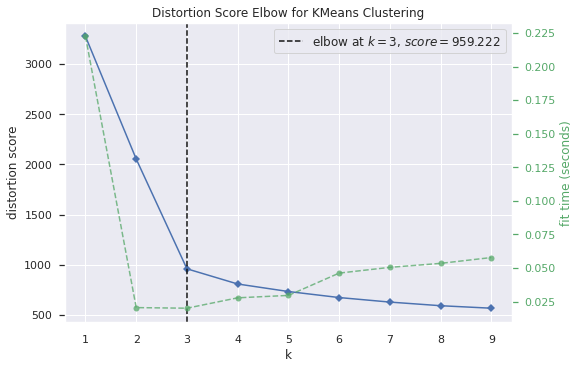

In [21]:
seed = 17  # random_state

# metrics = "distortion", which computes the sum of squared distances from each point to its assigned center.
visualizer = KElbowVisualizer(estimator = KMeans(), metric = "distortion", k=(1,10))
visualizer.fit(scaled_df);
visualizer.show();  # show distortion score and fit time for each k

- k = 3 is an elbow point that achieves a balance of accuracy and compression.

**Silhouette Score Elbow Method**

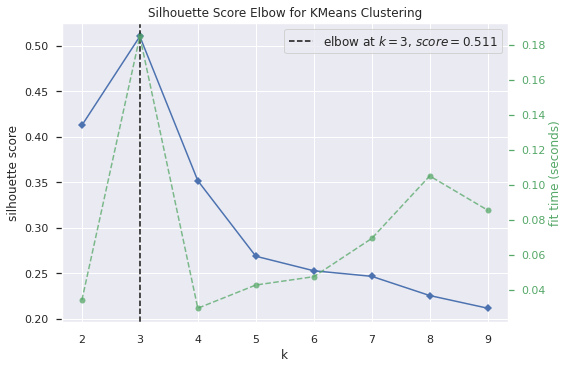

In [22]:
# metrics = "silhouette", which calculates the mean Silhouette Coefficient of all samples
# Silhouette Coefficient is only defined for 2 <= n_labels <= (n_samples - 1)
visualizer = KElbowVisualizer(estimator = KMeans(), metric = "silhouette", k=(2,10))
visualizer.fit(scaled_df);
visualizer.show(); # show silhouette score and fit time for each k

- k = 3 achieves the highest silhouette score of 0.511.

**Visualize the silhouette coefficient for each sample on a per-cluster basis**

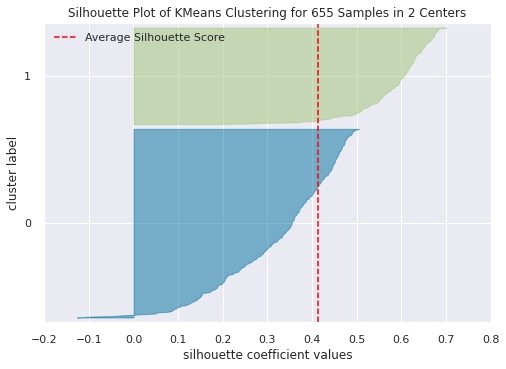

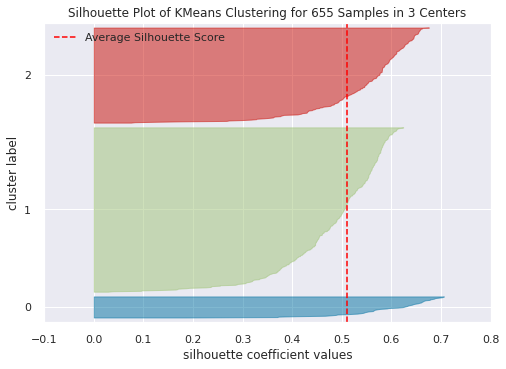

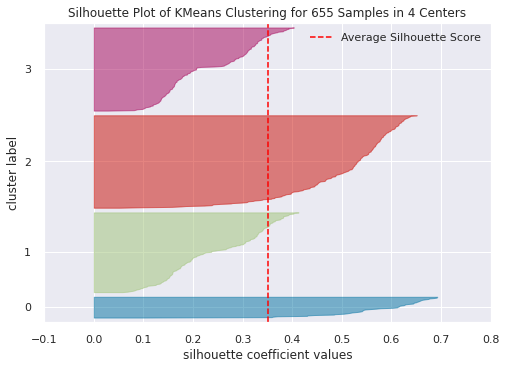

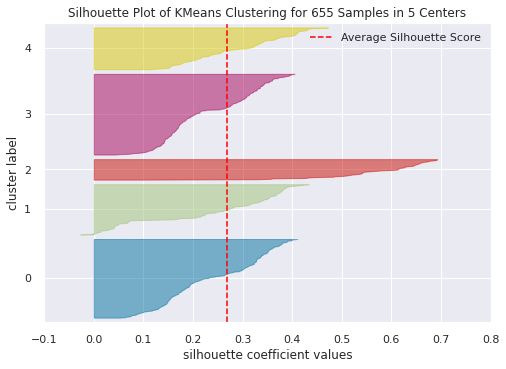

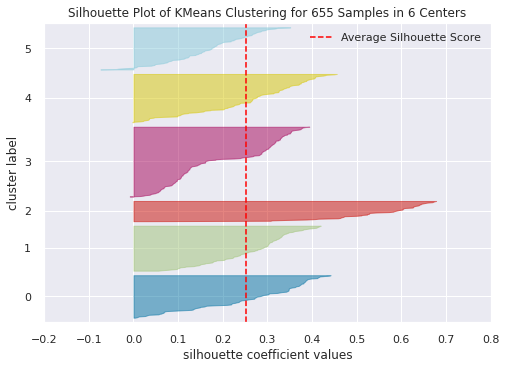

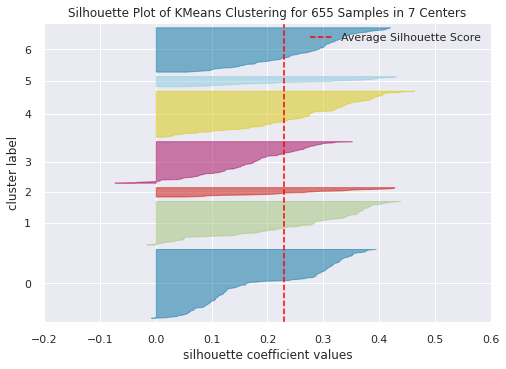

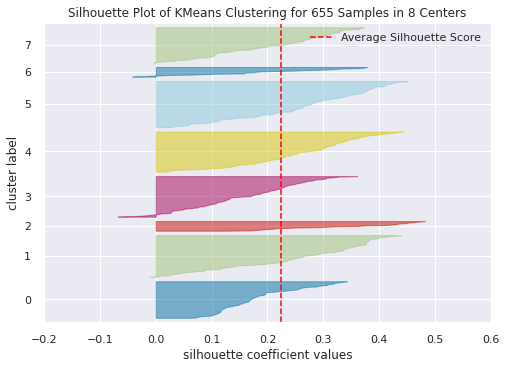

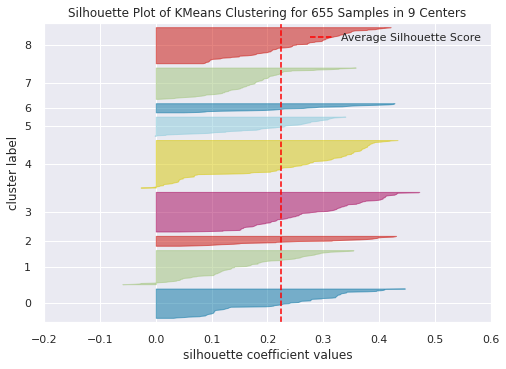

In [23]:
for k in range(2, 10):
    visualizer = SilhouetteVisualizer(KMeans(n_clusters = k, random_state = seed), colors='yellowbrick')
    visualizer.fit(scaled_df)
    visualizer.show() 

- k = 2: a few observations in cluster 0 get negative silhouette scores.
- k = 3: all clusters have reasonable size and all observations get positive silhouette score.
- k > 3: some clusters have too few observations and become more overfitting with k increasing.

**Use k = 3 to build the final model**

In [24]:
km = KMeans(n_clusters = 3, random_state = seed).fit(scaled_df)
df["Labels_KMeans"] = km.labels_
df.head()

,Customer_Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,Labels_KMeans
0,87073,100000,2,1,1,0,1
1,38414,50000,3,0,10,9,2
2,17341,50000,7,1,3,4,1
3,40496,30000,5,1,1,4,1
4,47437,117000,13,3,13,3,0


## Cluster Profile

In [25]:
cluster_profile_km = df.groupby(by = "Labels_KMeans").describe()
cluster_profile_km.drop(columns = "Customer_Key", inplace = True)
cluster_profile_km

Avg_Credit_Limit                                        \
                         count           mean           std      min   
Labels_KMeans                                                          
0                         50.0  141720.000000  34671.072457  84000.0   
1                        383.0   34018.276762  22535.421337   5000.0   
2                        222.0   12180.180180   5246.327219   3000.0   

                                                      Total_Credit_Cards  \
                    25%       50%       75%       max              count   
Labels_KMeans                                                              
0              111250.0  145500.0  170000.0  204000.0               50.0   
1               13000.0   31000.0   52000.0  104000.0              383.0   
2                8000.0   12000.0   16000.0   50000.0              222.0   

                                                              \
                   mean       std  min  25%  50%   75%   max   
Labels_KMeans                                                  
0              8.920000  1.322336  5.0  8.0  9.0  10.0  13.0   
1              5.550914  1.211590  2.0  4.0  6.0   6.0  11.0   
2              2.405405  1.100213  1.0  1.0  2.0   3.0   4.0   

              Total_visits_bank                                                \
                          count      mean       std  min  25%  50%  75%   max   
Labels_KMeans                                                                   
0                          50.0  0.680000  0.620730  0.0  0.0  1.0  1.0   3.0   
1                         383.0  3.509138  1.190844  1.0  3.0  3.0  5.0  10.0   
2                         222.0  0.936937  0.804729  0.0  0.0  1.0  2.0   2.0   

              Total_visits_online                                              \
                            count       mean       std  min   25%   50%   75%   
Labels_KMeans                                                                   
0                            50.0  10.960000  2.849705  6.0  8.25  11.0  13.0   
1                           383.0   0.992167  0.863720  0.0  0.00   1.0   2.0   
2                           222.0   3.567568  1.215448  1.0  3.00   4.0   4.0   

                    Total_calls_made                                          \
                max            count      mean       std  min  25%  50%  75%   
Labels_KMeans                                                                  
0              15.0             50.0  1.280000  1.525832  0.0  0.0  1.0  2.0   
1               3.0            383.0  2.036554  1.489482  0.0  1.0  2.0  3.0   
2              10.0            222.0  6.851351  1.986487  1.0  5.0  7.0  9.0   

                     
                max  
Labels_KMeans        
0              10.0  
1              10.0  
2              10.0

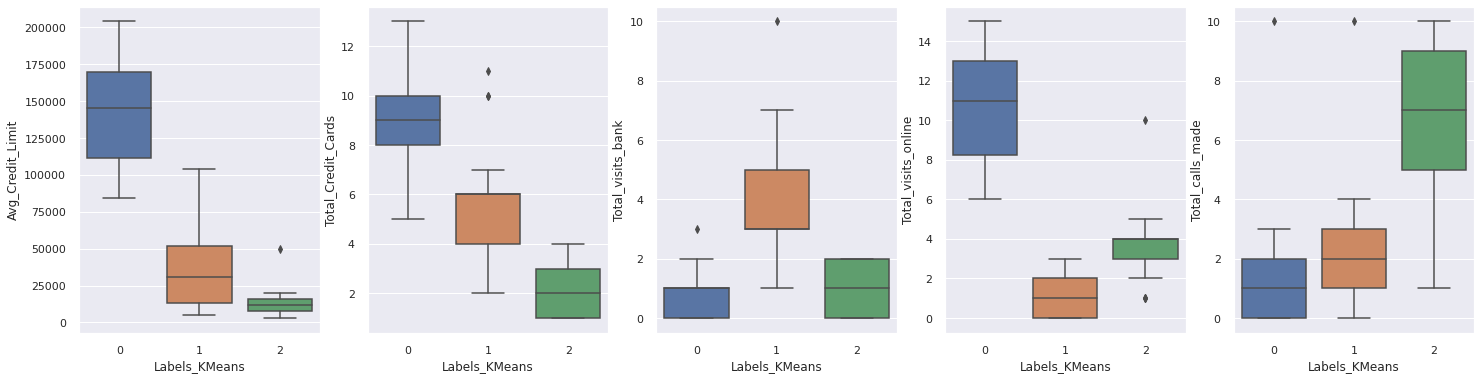

In [26]:
plt.figure(figsize = (25, 6))
for i, col in enumerate(attribute_cols):
    plt.subplot(1, 5, i + 1)
    sns.boxplot(x = "Labels_KMeans", y = col, data = df);

## Insights:
### Cluster 0
- 50 customers in cluster 0.
- Credit limit is the highest, ranging from 84000 to 200000. Average is around 140000.
- The number of credit cards is the highest, ranging from 5 - 13.
- Seldom visit the bank or call the bank.
- Frequently use online service, ranging from 6 - 15 times yearly.
- These are our premium customers, as they have the highest credit limits and could spend more. Their preference to online service shows they're educated and comfortable to search for support information with internet rather than asking people for help. They could be working professionals who don't have much time to visit our bank or schedule a phone call to talk. Or they could be educated people with introverted personality.

### Cluster 1:
- 383 customers in cluster 1.
- Credit limit is moderate, ranging from 5000 to 100000. Average is around 34000.
- The number of credit cards is reasonable, ranging from 2 - 7.
- Prefer visiting the bank to making phone calls or using online service.
- These are our major customers who have moderate credit limits. They frequently visit our bank, indicating they may live near our branches and enjoy talking to live agents face to face for help. Or they could be elderly who are not so good at internet navigation.

### Cluster 2:
- 222 customers in cluster 2.
- Lowest credit limit, mostly less than 25000.
- Have very few credit cards, ranging from 1 - 4.
- Seldom visit the bank.
- Sometimes use online service.
- Mainly contact our bank by phone.
- These are our regular customers, who may not have as good solvency as the other two clusters. They may live far from our branches and not always have access to internet. So they prefer talking to live representatives on phone.




# Hierarchical Clustering

Try combinations of different methods and metrics, compute cophenetic correlation and show the corresponding dendrogram.

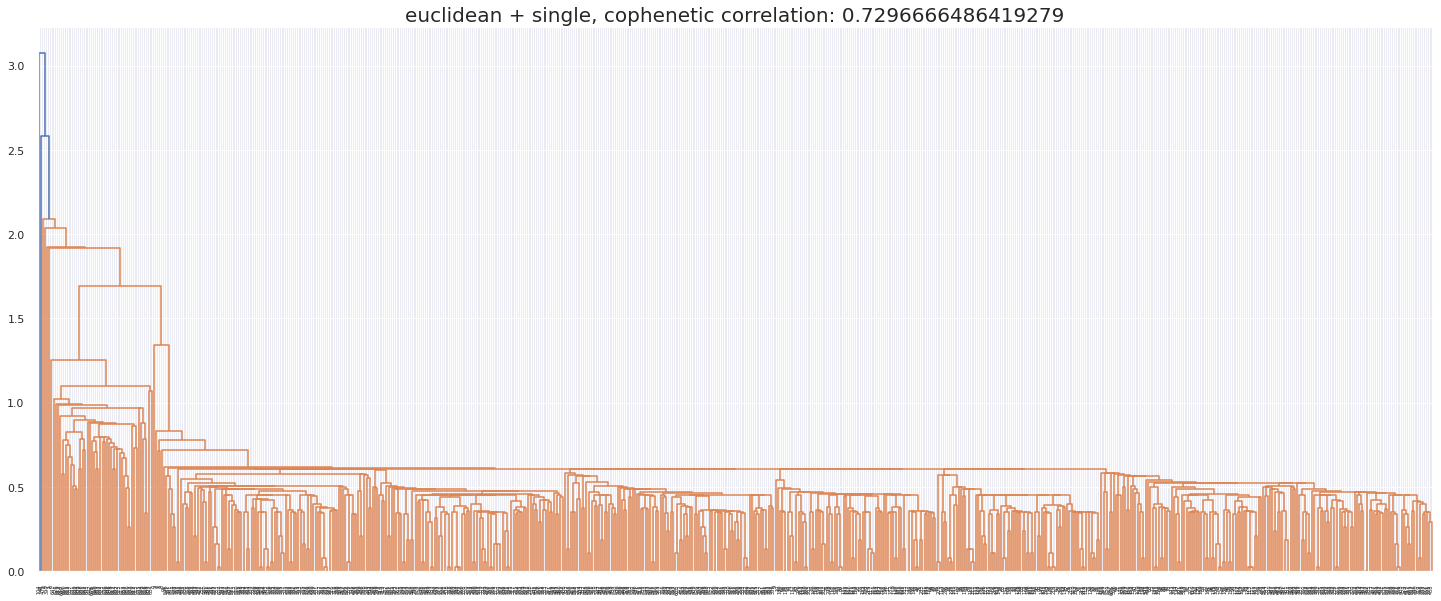

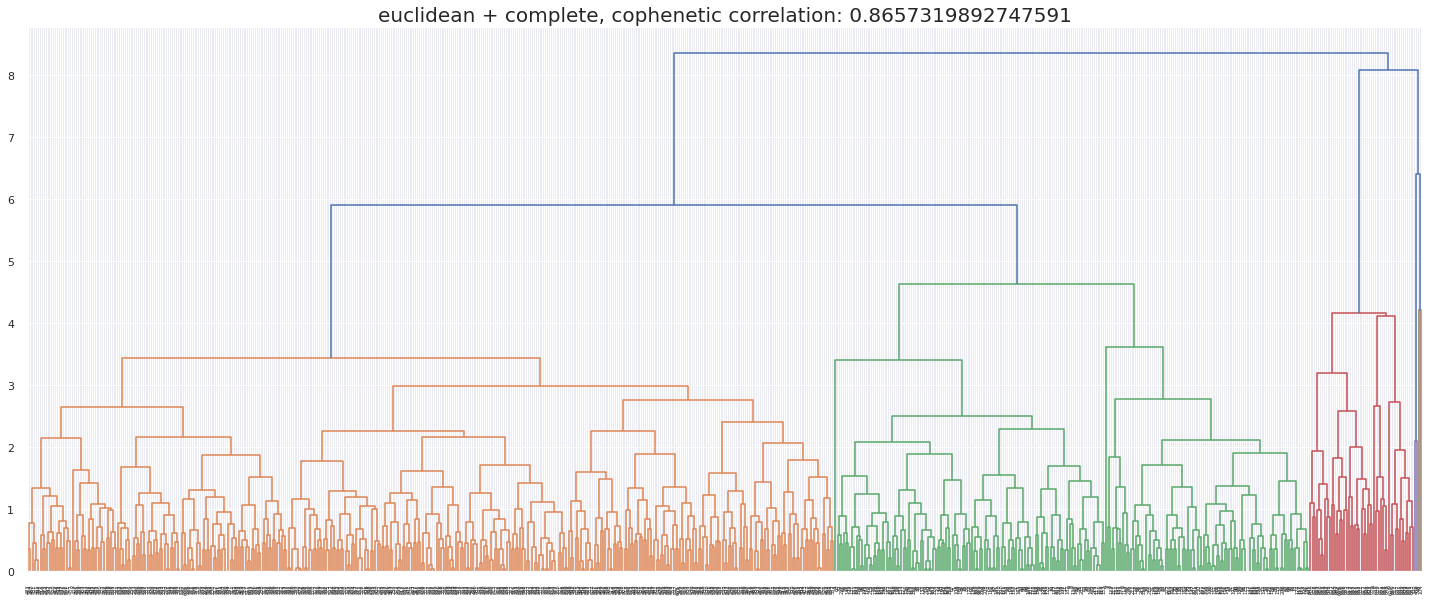

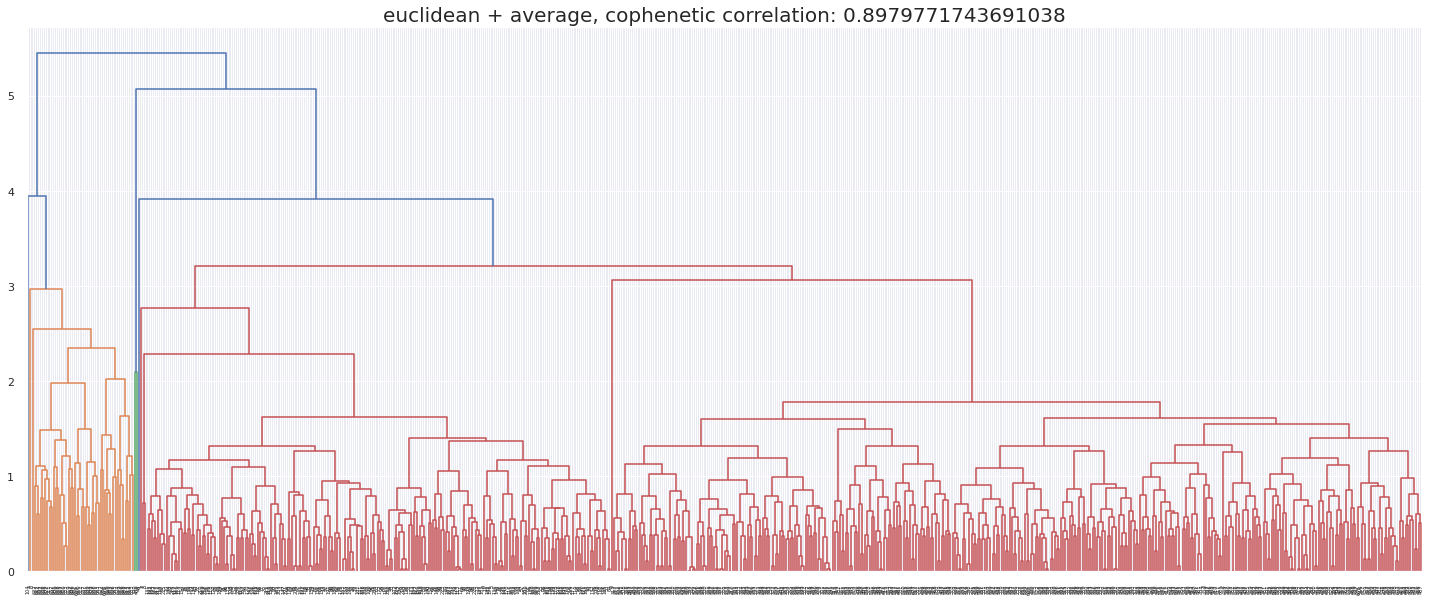

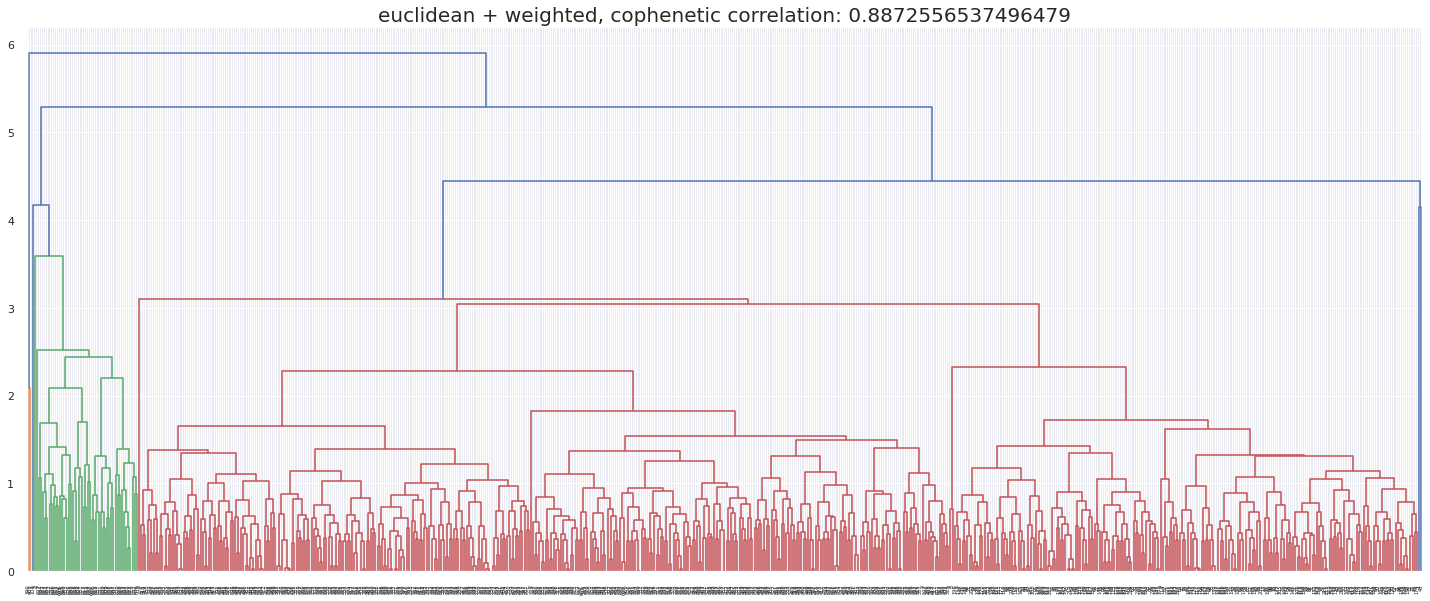

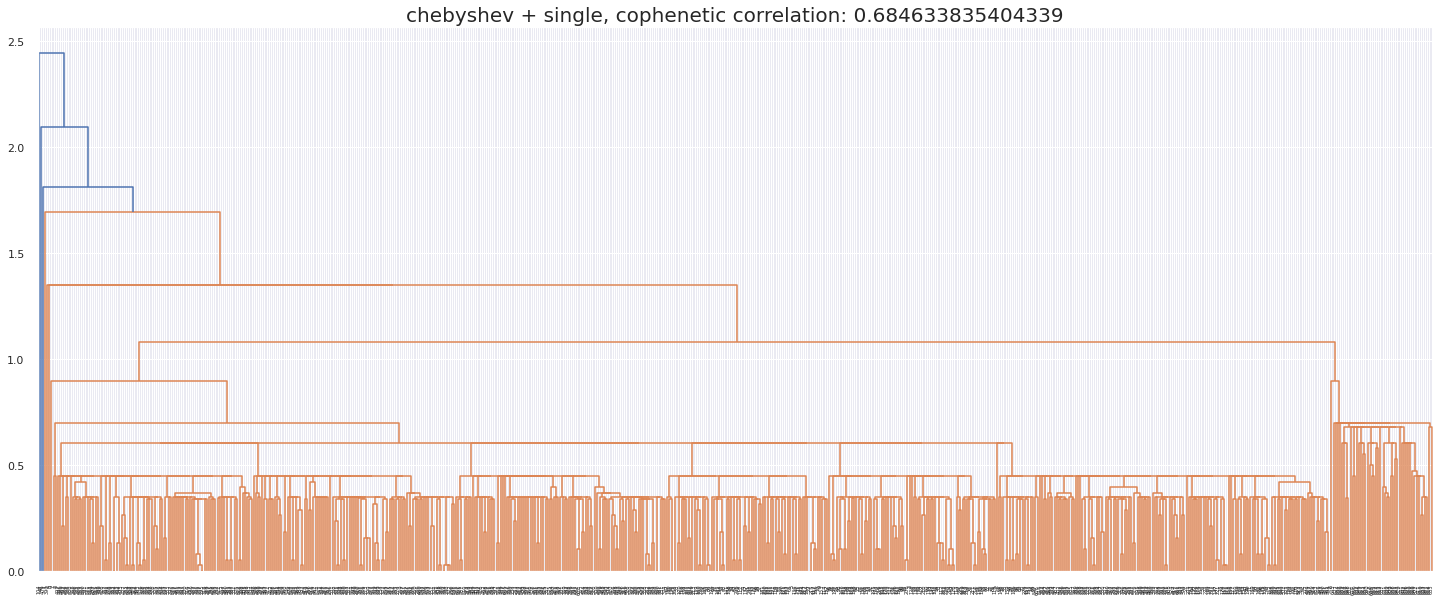

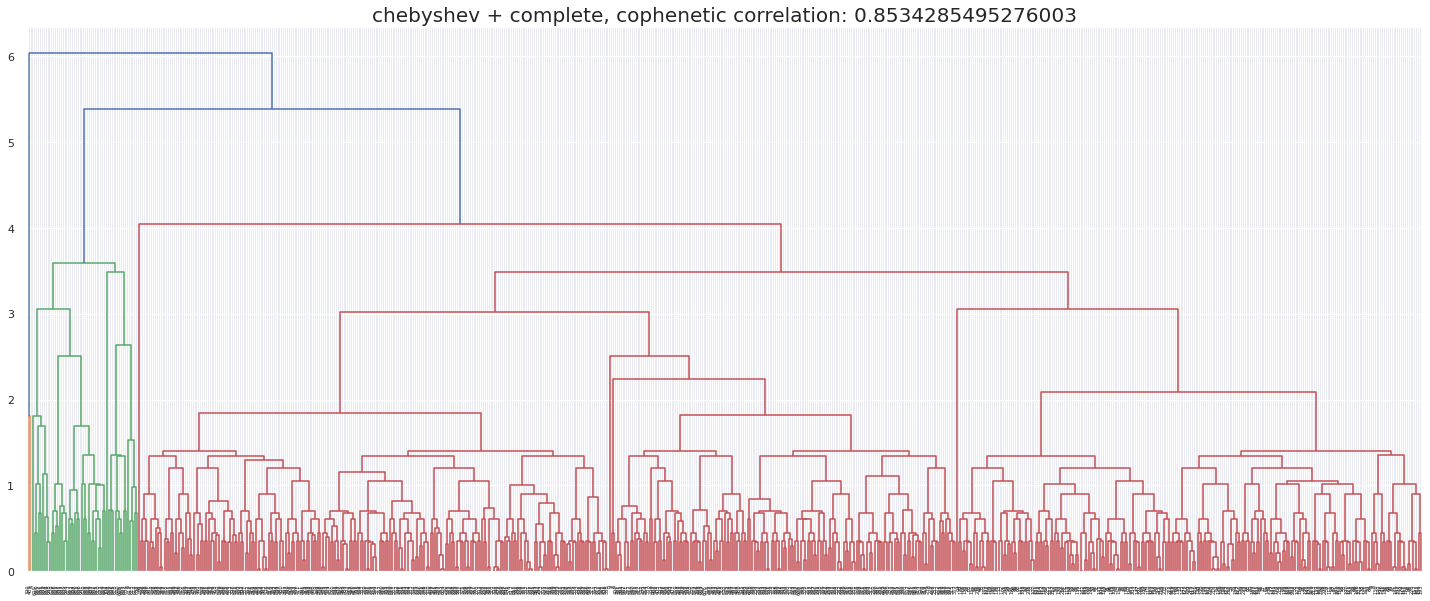

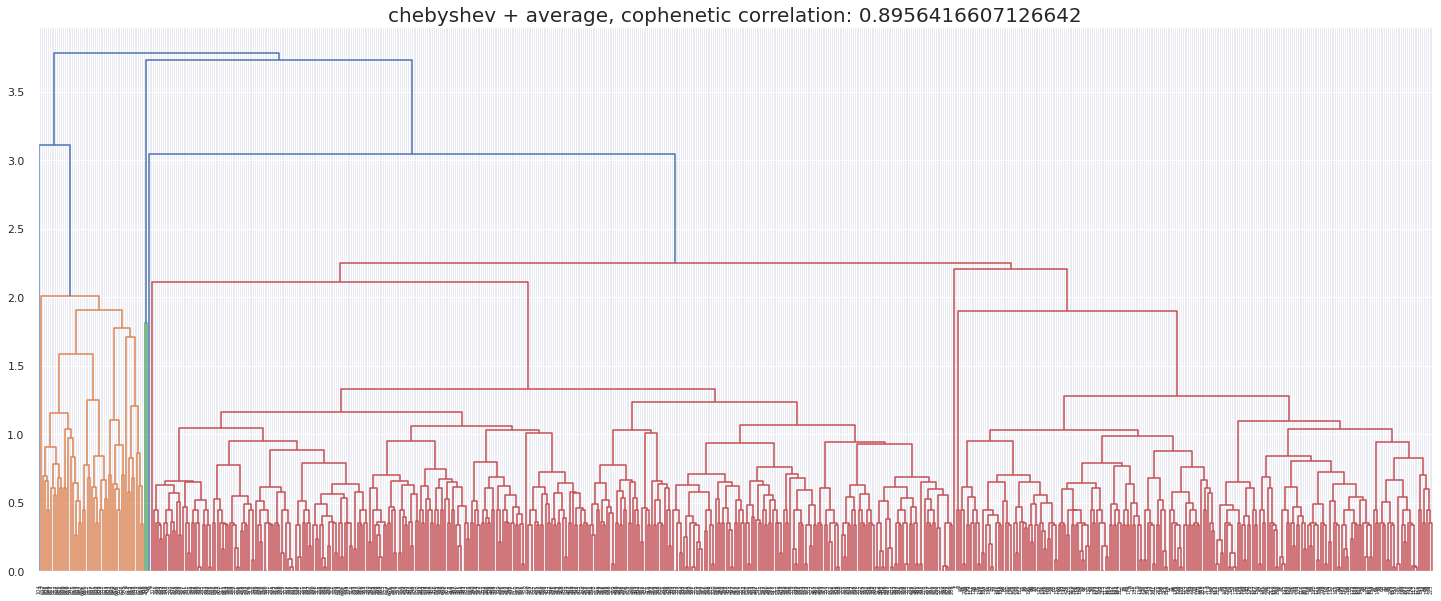

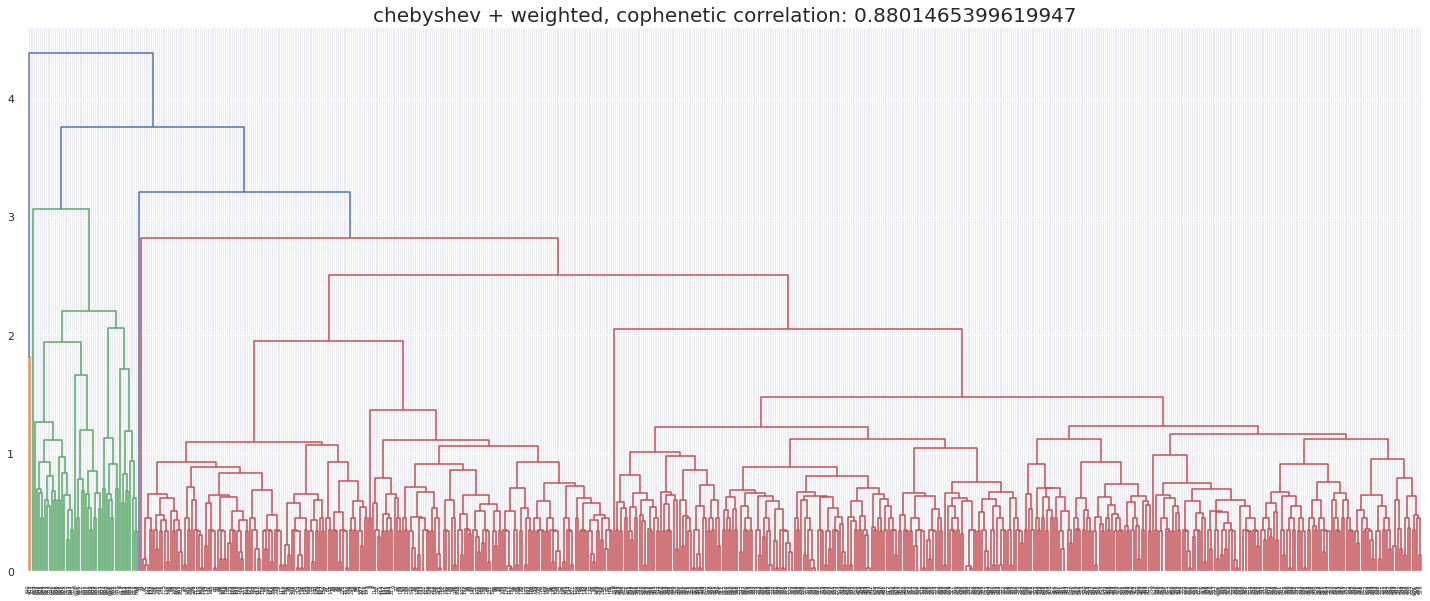

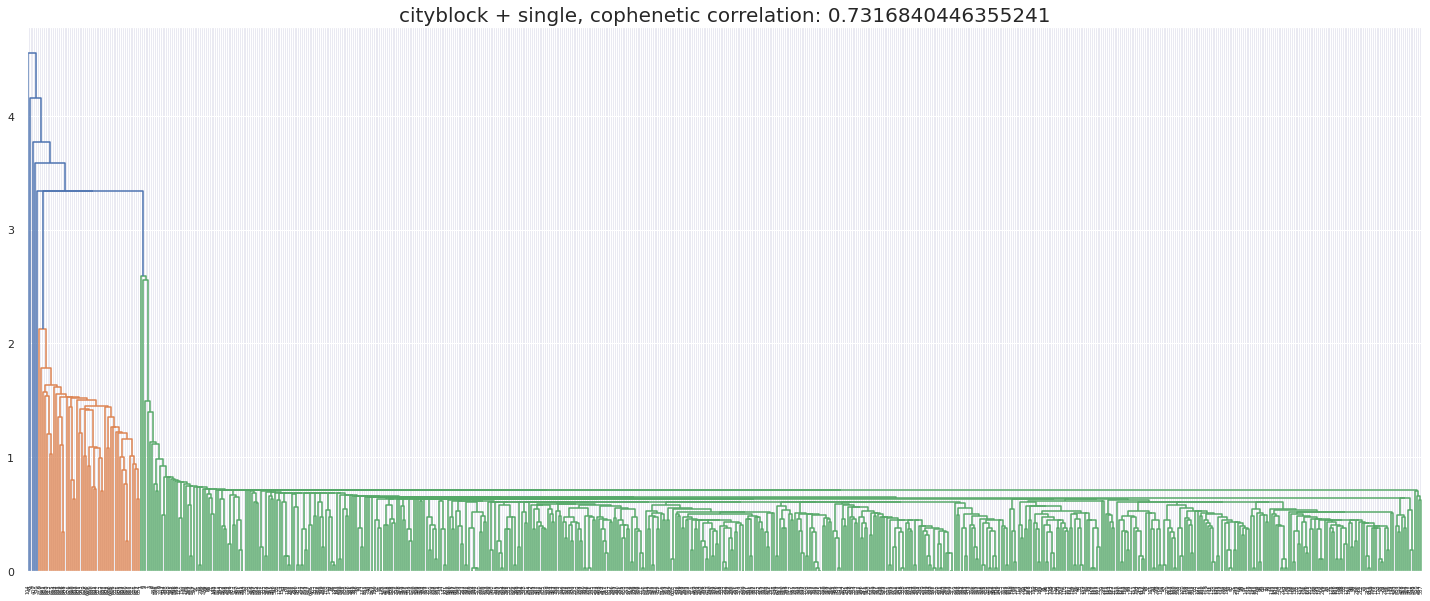

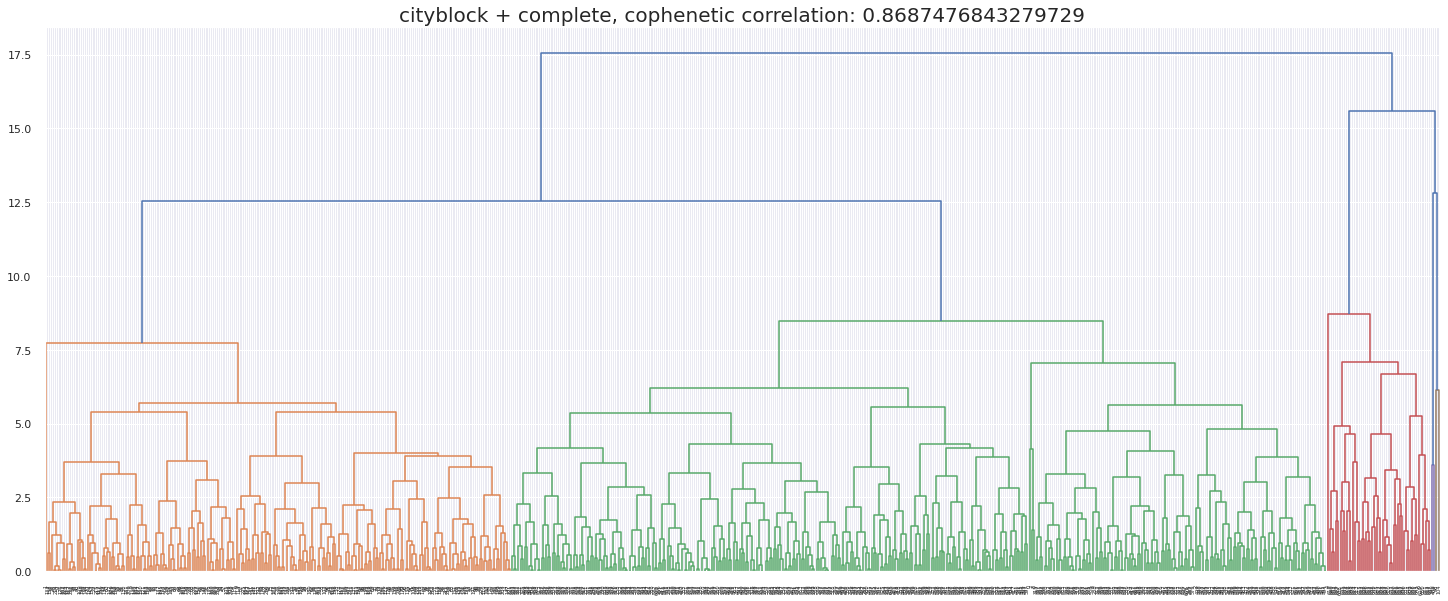

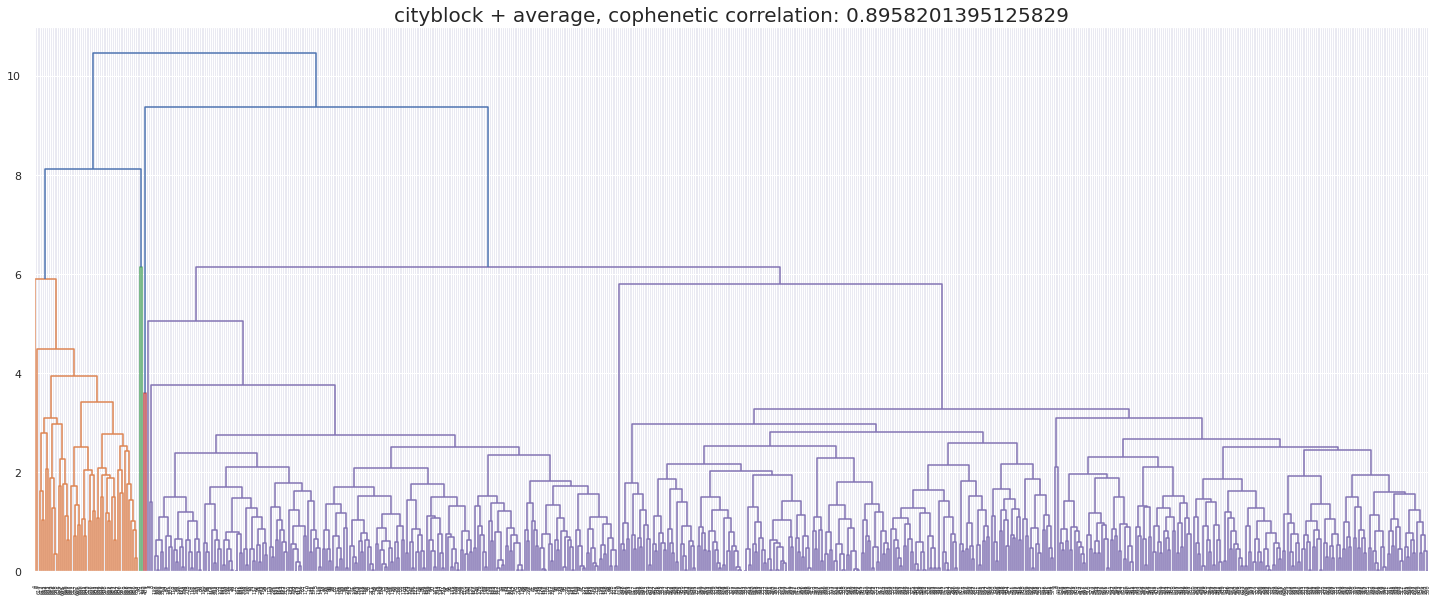

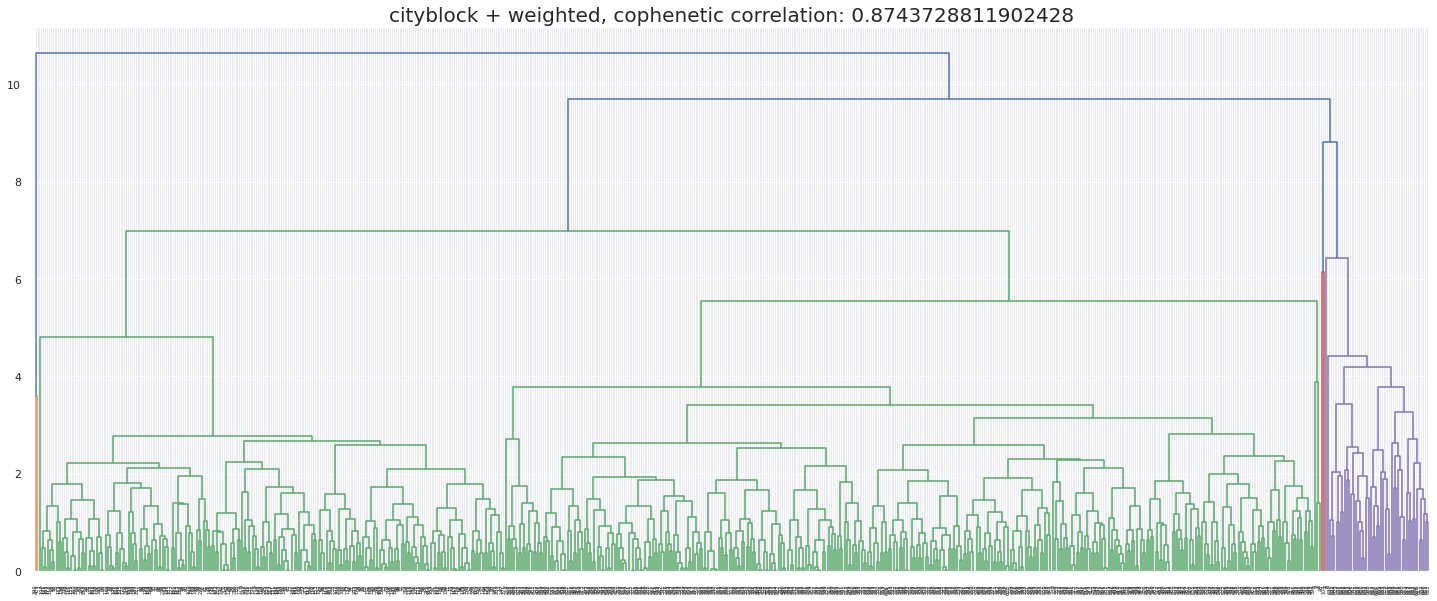

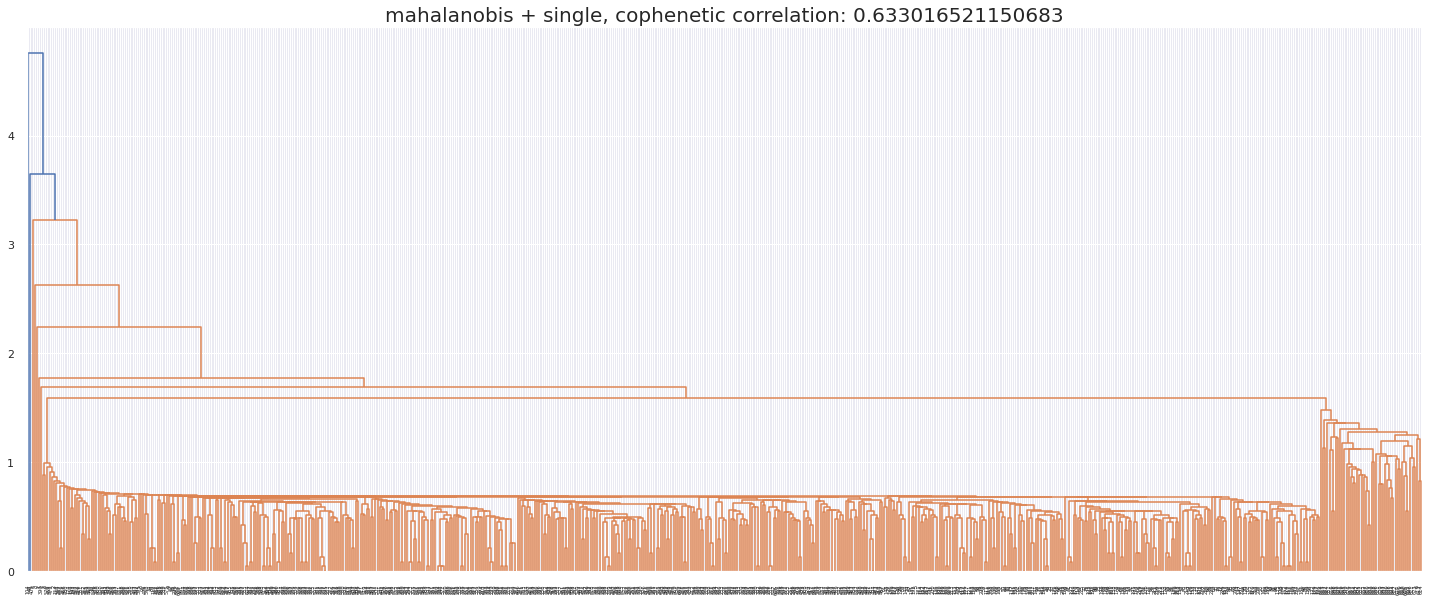

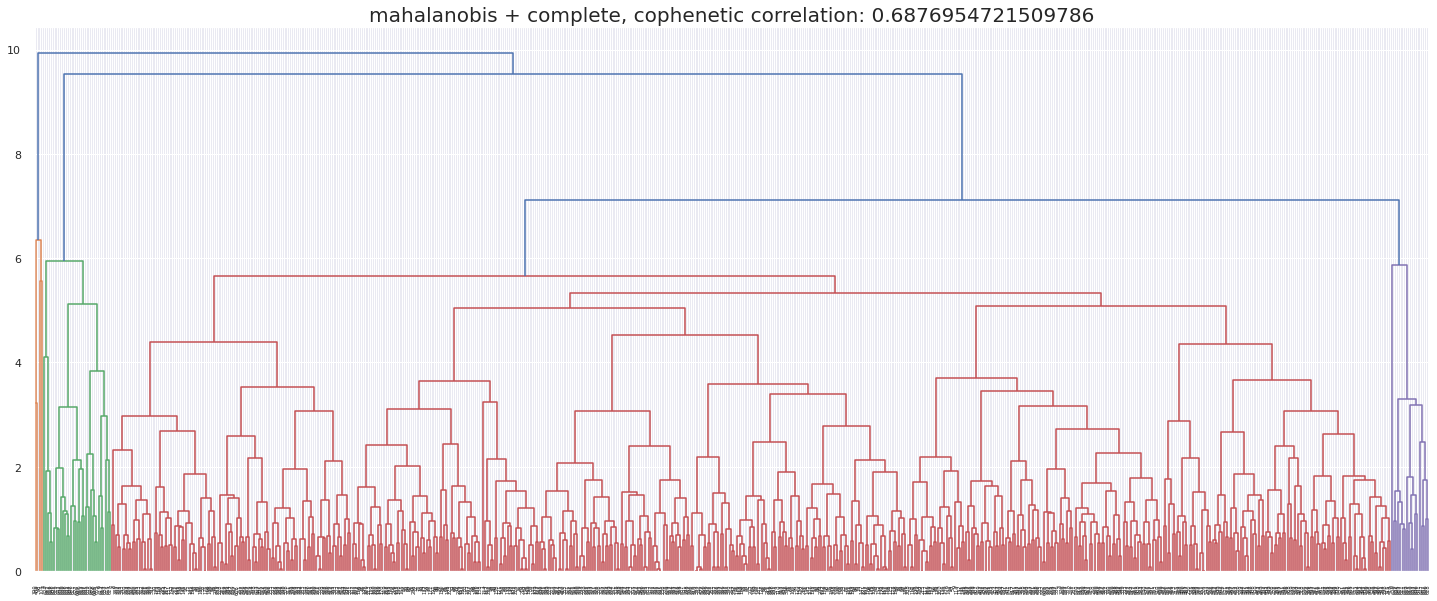

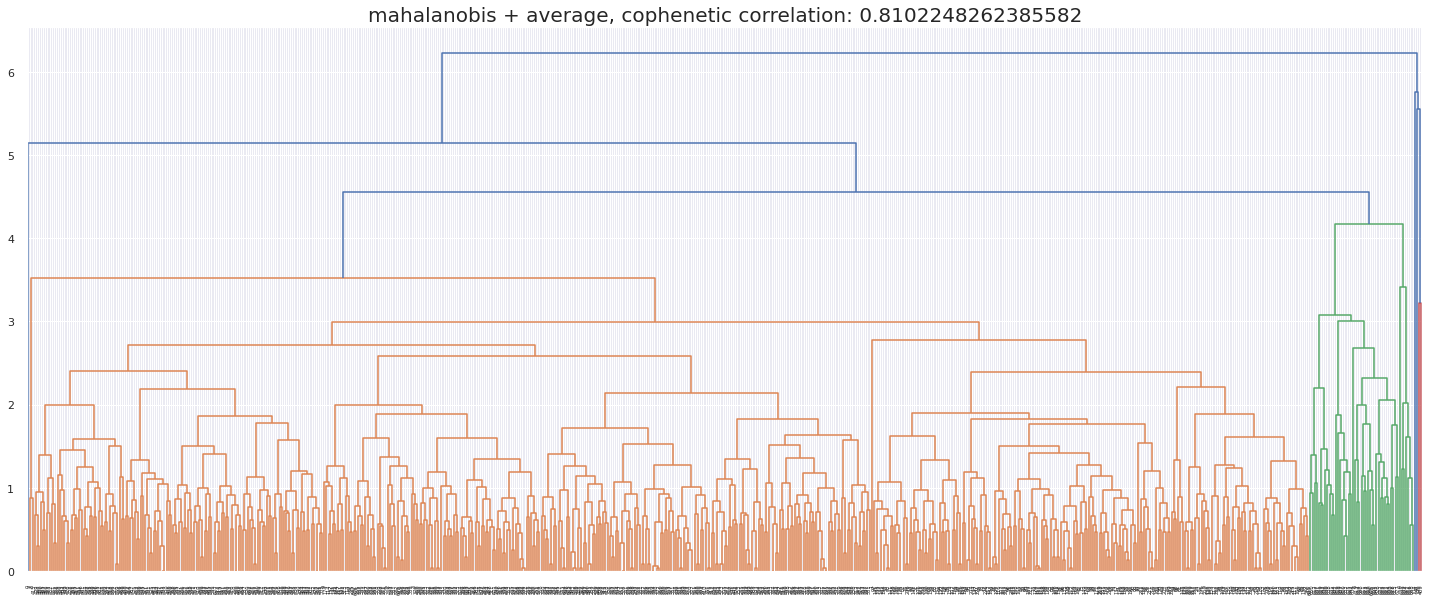

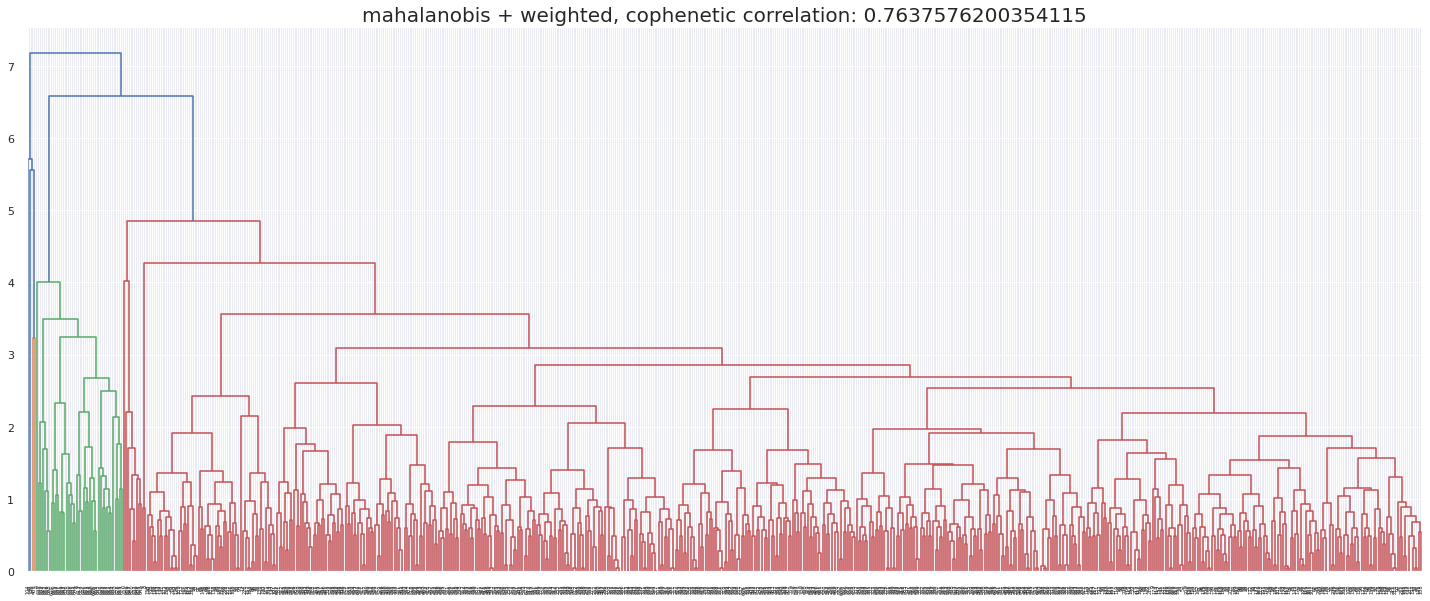

In [27]:
combinations = []
metrics = ('euclidean', 'chebyshev', 'cityblock', 'mahalanobis')
methods = ('single', 'complete', 'average', 'weighted') 

for metric in metrics:
    for method in methods:
        linkage_matrix = linkage(scaled_df, method = method, metric = metric)
        plt.figure(figsize=(25, 10))
        dendrogram(linkage_matrix)
        condense_dist_matrix = pdist(scaled_df)
        coph_corr, coph_dist_matrix = cophenet(Z = linkage_matrix, Y = condense_dist_matrix)
        plt.title(label = "{} + {}, cophenetic correlation: {}".format(metric, method, coph_corr), fontsize = 20)
        combinations.append([metric, method, coph_corr])

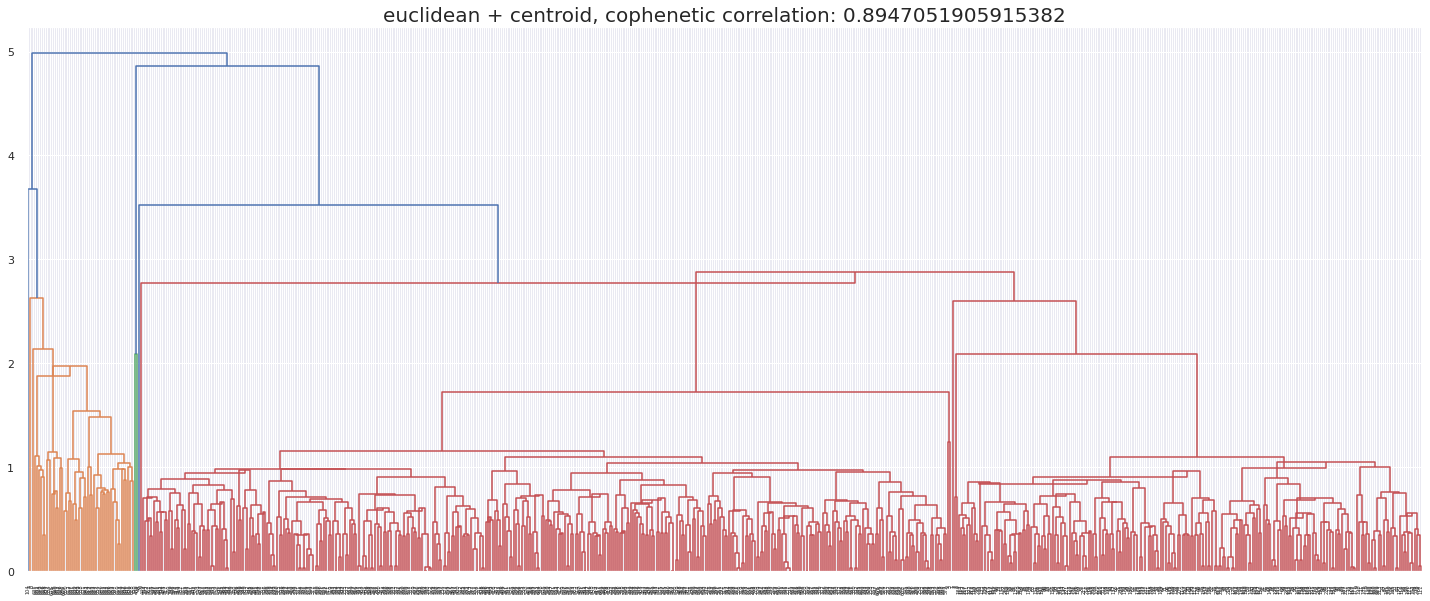

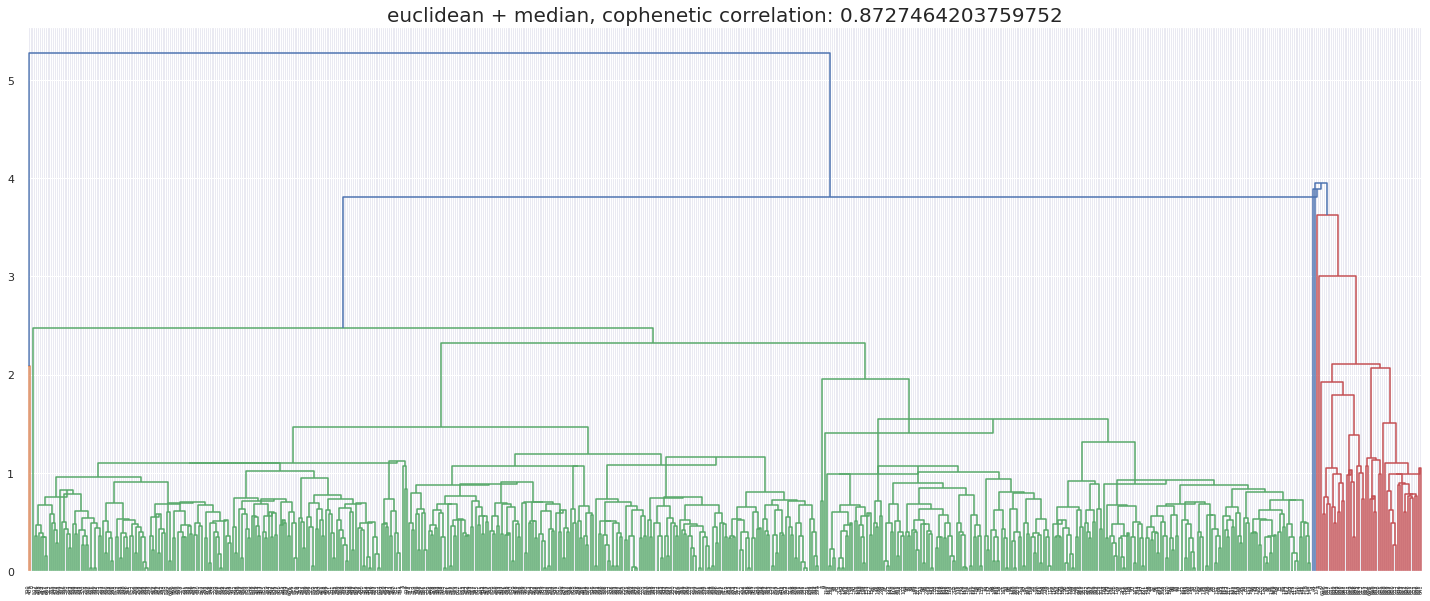

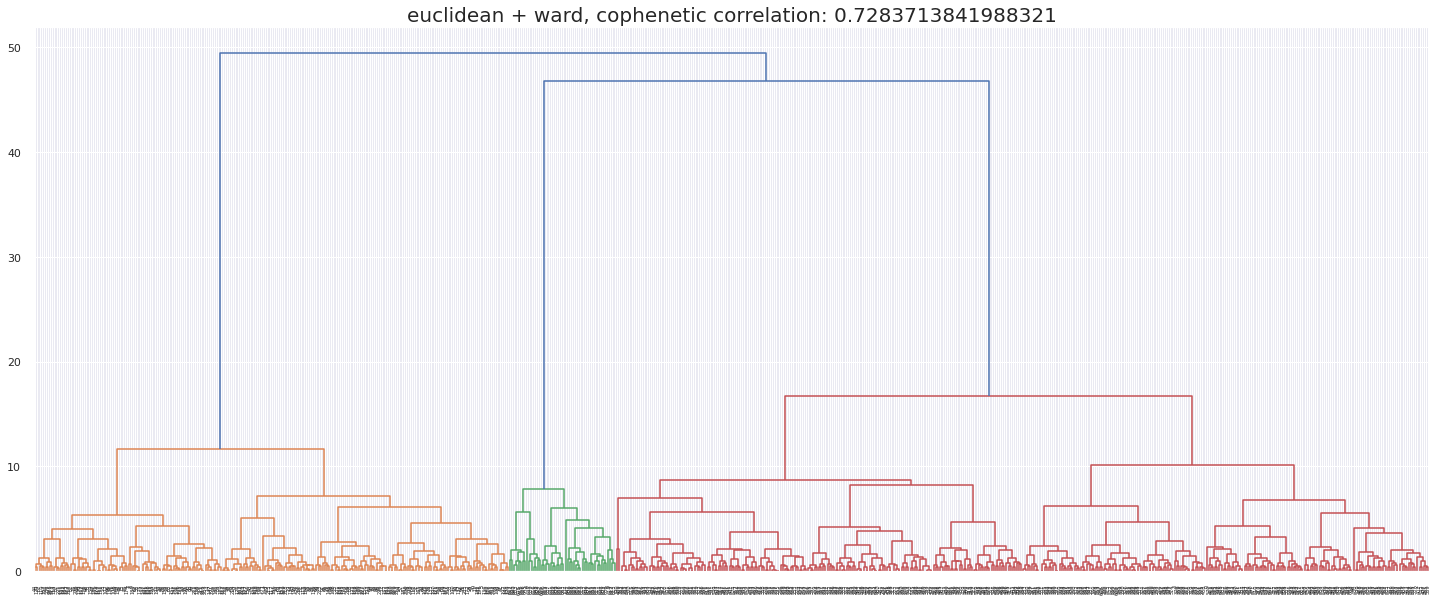

In [28]:
methods = ("centroid", "median", "ward")    # "centroid", median" and "ward" could only work with "euclidean" metric

for method in methods:
    linkage_matrix = linkage(scaled_df, method = method)
    plt.figure(figsize=(25, 10))
    dendrogram(linkage_matrix)
    condense_dist_matrix = pdist(scaled_df)
    coph_corr, coph_dist_matrix = cophenet(Z = linkage_matrix, Y = condense_dist_matrix)
    plt.title(label = "euclidean + {}, cophenetic correlation: {}".format(method, coph_corr), fontsize = 20)
    combinations.append(["euclidean", method, coph_corr])

In [29]:
cm = pd.DataFrame(data = combinations, columns = ["metric", "method", "cophenetic correlation"])
cm.sort_values(by = "cophenetic correlation", ascending = False)  # sort by cophenetic correlation

,metric,method,cophenetic correlation
2,euclidean,average,0.897977
10,cityblock,average,0.895820
6,chebyshev,average,0.895642
16,euclidean,centroid,0.894705
3,euclidean,weighted,0.887256
7,chebyshev,weighted,0.880147
11,cityblock,weighted,0.874373
17,euclidean,median,0.872746
9,cityblock,complete,0.868748
1,euclidean,complete,0.865732


- The combination of "euclidean" + "average" achieves the highest cophenetic correlation of 0.898. However, the clusters are not separated well and the differences between dendrogram distances are small.

- The combination of "euclidean" + "ward" divides the data into distinct clusters with reasonable size, and the differences between dendrogram distances is large. Cophenetic correlation is 0.728.

**Use "euclidean" + "ward" to build the final model. Now we need to find out the optimal number of clusters.**

k = 2, silhouette score is 0.41204169811737096
k = 3, silhouette score is 0.5096116341342978
k = 4, silhouette score is 0.3450125561996107
k = 5, silhouette score is 0.24713404280891144
k = 6, silhouette score is 0.2219240072234884
k = 7, silhouette score is 0.21294892905628812
k = 8, silhouette score is 0.2140064988379448
k = 9, silhouette score is 0.19100143043090198


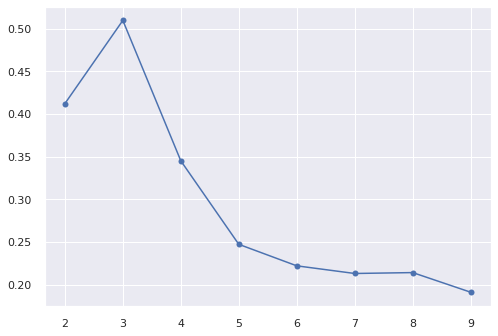

In [30]:
silhouette_scores = []

for k in range(2, 10):
    hc = AgglomerativeClustering(n_clusters = k).fit(scaled_df)
    score = silhouette_score(scaled_df, hc.labels_, random_state = seed)
    silhouette_scores.append(score)
    print("k = {}, silhouette score is {}".format(k, score))
    
plt.plot(range(2,10), silhouette_scores, "o-");

- Silhouette score is the highest when it's divided into 3 clusters.
- Silhouette score is equal to the result of k-means clustering.

In [31]:
hc = AgglomerativeClustering(n_clusters = 3, affinity='euclidean', linkage = 'ward').fit(scaled_df)
df["Labels_HC"] = hc.labels_
df.head()

,Customer_Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,Labels_KMeans,Labels_HC
0,87073,100000,2,1,1,0,1,0
1,38414,50000,3,0,10,9,2,1
2,17341,50000,7,1,3,4,1,0
3,40496,30000,5,1,1,4,1,0
4,47437,117000,13,3,13,3,0,2


## Cluster Profile

In [32]:
cluster_profile_hc = df.groupby(by = "Labels_HC").describe()
cluster_profile_hc.drop(columns = ["Customer_Key", "Labels_KMeans"], inplace = True)
cluster_profile_hc

Avg_Credit_Limit                                                  \
                     count           mean           std      min       25%   
Labels_HC                                                                    
0                    382.0   34089.005236  22522.369972   5000.0   13000.0   
1                    223.0   12156.950673   5245.979467   3000.0    8000.0   
2                     50.0  141720.000000  34671.072457  84000.0  111250.0   

                                        Total_Credit_Cards            \
                50%       75%       max              count      mean   
Labels_HC                                                              
0           31500.0   52000.0  104000.0              382.0  5.552356   
1           12000.0   16000.0   50000.0              223.0  2.417040   
2          145500.0  170000.0  204000.0               50.0  8.920000   

                                               Total_visits_bank            \
                std  min  25%  50%   75%   max             count      mean   
Labels_HC                                                                    
0          1.212850  2.0  4.0  6.0   6.0  11.0             382.0  3.513089   
1          1.111397  1.0  1.0  2.0   3.0   5.0             223.0  0.941704   
2          1.322336  5.0  8.0  9.0  10.0  13.0              50.0  0.680000   

                                              Total_visits_online             \
                std  min  25%  50%  75%   max               count       mean   
Labels_HC                                                                      
0          1.189890  1.0  3.0  3.0  5.0  10.0               382.0   0.989529   
1          0.806064  0.0  0.0  1.0  2.0   2.0               223.0   3.560538   
2          0.620730  0.0  0.0  1.0  1.0   3.0                50.0  10.960000   

                                                 Total_calls_made            \
                std  min   25%   50%   75%   max            count      mean   
Labels_HC                                                                     
0          0.863306  0.0  0.00   1.0   2.0   3.0            382.0  2.031414   
1          1.217242  1.0  2.50   4.0   4.0  10.0            223.0  6.838565   
2          2.849705  6.0  8.25  11.0  13.0  15.0             50.0  1.280000   

                                               
                std  min  25%  50%  75%   max  
Labels_HC                                      
0          1.488030  0.0  1.0  2.0  3.0  10.0  
1          1.991184  1.0  5.0  7.0  9.0  10.0  
2          1.525832  0.0  0.0  1.0  2.0  10.0

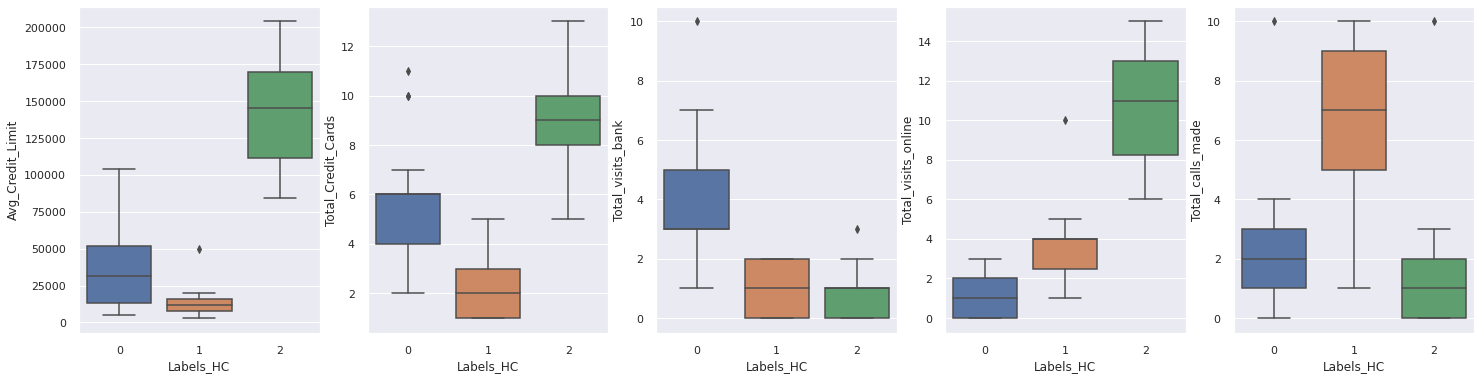

In [33]:
plt.figure(figsize = (25, 6))
for i, col in enumerate(attribute_cols):
    plt.subplot(1, 5, i + 1)
    sns.boxplot(x = "Labels_HC", y = col, data = df);

## Insights:
- The result is almost the same as that of K-means clustering.
- The relationship between the results obtained by two methods is: 
    - cluster 2 in HC = cluster 0 in KMeans
    - cluster 0 in HC = cluster 1 in KMeans
    - cluster 1 in HC = cluster 2 in KMeans


# Conclusion

- Customers with higher credit limit tend to have more credit cards.
- Customers with higher credit limit/ more credit cards are more likely to use online service and less likely to contact the bank by phone.
- Customers seldom visiting the bank are more likely to use online service and call customer service.
- 3 would be a reasonable number of clusters for this dataset. Obtain identical silhouette scores and cluster profiles from KMeans clustering and Hierarchical clustering.


# Recommendation
## For Marketing Team
- Online advertising should be the major marketing approach for premium customers with credit limit ranging from 84000 to 200000. Marketing information could be displayed on our website, mobile app banners/ popup notifications and other social mediums.
- Flyer/ poster, billboard/ lightbox ads at our branches and account managers/ salespeople marketing should be the major marketing approach for major customers with credit limit ranging from 5000 to 100000. 
- Telesales and promotional messages via SMS should be the major marketing approach for regular customers with credit limit lower than 25000.

## For Operation Team
- For premium customers, deploy AI-driven virtual financial assistant and chatbot/online chat on our website/ mobile app, to help with accessing account information, transferring money between accounts, handling queries and scheduling necessary meetings at branches.
- For major customers, provide trainings for account managers/bank tellers in communication skills and routine transactions, to promptly solve users' queries and smoothly close the transaction. 
- For regular customers, provide trainings for call center representatives in communication skills and trouble shooting skills, to address users' queries and concerns.
- Regularly collect customers' feedback regarding our customer service and improve its quality.    